In [4]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
draft_years = [i for i in range(2000, 2017)]

### Get all draft picks from 1990 to 2016

In [10]:
all_drafts = pd.read_html("https://www.basketball-reference.com/draft/NBA_2017.html#stats")[0]
all_drafts.drop([30,31], axis=0, inplace=True)
years = [2017 for i in range(all_drafts.shape[0])]

for year in draft_years:
    
    url = f"https://www.basketball-reference.com/draft/NBA_{year}.html#stats"
    df = pd.read_html(url)[0]
    
    if year >= 2005:
        df.drop([30,31], axis=0, inplace=True)
    elif year == 2004:
        df.drop([29,30,31], axis=0, inplace=True)
    elif year in [2003,2000,1999,1998,1996,1995]:
        df.drop([29,30], axis=0, inplace=True)
    elif year in [2002,2001,1997]:
        df.drop([28,29,30], axis=0, inplace=True)
    else:
        df.drop([27,28], axis=0, inplace=True)

    years.extend(year for i in range(df.shape[0]))
    
    all_drafts = pd.concat([all_drafts, df], axis=0)

In [11]:
# clean draft data

all_drafts.columns = ['rank', 'overall_pick', 'team', 'player', 'college',
                      'YRS', 'G', 'MP', 'PTS', 'TRB', 'AST', 'FG_percent', '3P_percent', 'FT_percent',
                      'MP_PG', 'PTS_PG', 'TRB_PG', 'AST_PG',
                      'WS', 'WS_per_48', 'BPM', 'VORP']
all_drafts["draft_year"] = years

all_drafts["YRS"] = pd.to_numeric(all_drafts["YRS"])
all_drafts = all_drafts[all_drafts["YRS"] >= 2]
all_drafts = all_drafts[all_drafts['college'].notnull()]

all_drafts.reset_index(inplace=True)
all_drafts.drop(columns=["index"], inplace=True)

In [ ]:
all_drafts.to_excel("draft_data.xlsx")

### Get all college stats for all draftees

In [57]:
# create empty DF to concatenate all dataframes

df = pd.DataFrame(columns=['Season', 'School', 'Conf', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '2P',
       '2PA', '2P%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Unnamed: 27', 'SOS'])

missed_players = []
counter = 0
players = []
years_played = []

In [58]:
def format_player_name(player_name):
    """
    formats irregular european names that are non-ascii or
    other irregular names e.g. Jr. or III, etc.
    player_name: str
    return: str
    """
    player_name = player_name.lower().replace(
                                "'", "").replace(
                                ".", "").replace(
                                " iii", "").replace(
                                " jr", "").replace(
                                "è","e").replace(
                                "š","s").replace(
                                "ć","c").replace(
                                "í","i").replace(
                                "ó","o").replace(
                                "ô","o").replace(
                                "ï","i").replace(
                                "á","a").replace(
                                "ö","o").replace(
                                "ä","a").replace(
                                "ú","u").replace(
                                "č","c").replace(
                                "é","e")
    if player_name in ["glen rice", "tim hardaway"]:
        player_name += " jr"
    elif player_name == "metta world peace":
        player_name = "ron artest"
    elif player_name == "kay felder":
        player_name = "kahlil felder"
    elif player_name == "luc mbah a moute":
        player_name = "luc richard mbah a moute"
    elif player_name == "patty mills":
        player_name = "patrick mills"
    elif player_name == "henry walker":
        player_name = "bill walker"
    elif player_name == "byron mullens":
        player_name = "bj mullens"
    elif player_name == "jeff ayres":
        player_name = "jeff pendergraph"
    elif player_name == "devyn marble":
        player_name = "roy devyn marble"
    elif player_name == "jeff taylor":
        player_name = "jeffery taylor"
    elif player_name == "joe young":
        player_name = "joseph young"
    elif player_name == "bam adebayo":
        player_name = "edrice adebayo"
    elif player_name == "wes iwundu":
        player_name = "wesley iwundu"
    return player_name

In [83]:
# draftees college data gathering

for i in range(counter, all_drafts.shape[0]):
    player = all_drafts.iloc[i]["player"]
    player_formatted = format_player_name(player)

    name_url = ""
    player_lst = player_formatted.split(" ")

    for name in player_lst:
        name_url += name + "-"

    if (player_formatted in ["larry nance","thomas robinson","demetrius jackson",
                            "michael smith","mark davis","james cotton","cedric henderson",
                            "mike dunleavy","bobby jones","gerald henderson","james johnson",
                            "Derrick Williams","jordan hamilton","jared cunningham",
                            "justin hamilton","reggie bullock","ray mccallum","devin booker",
                            "josh richardson"]) or (
        player_formatted == "dee brown" and all_drafts.iloc[i]["college"] == "Illinois") or (
        player_formatted == "marcus williams" and all_drafts.iloc[i]["college"] == "Arizona") or (
        player_formatted == "glenn robinson" and all_drafts.iloc[i]["college"] == "Michigan"):
        name_url += "2"
    elif player_formatted in ["bernard james","joe harris"]:
        name_url += "-1"
    elif player_formatted in ["kyle anderson","charles smith","james anderson","ryan kelly"]:
        name_url += "3"
    elif player_formatted == "mike scott":
        name_url += "4"
    elif player_formatted in ["anthony davis","anthony brown"]:
        name_url += "5"
    else:
        name_url += "1"

    url = f"https://www.sports-reference.com/cbb/players/{name_url}.html#players_per_game"
    college_data = pd.read_html(url)[0]
    seasons_played = college_data[college_data["Season"] == "Career"].index.to_list()[0]
    df = pd.concat([df, college_data[college_data["Season"] == "Career"]], axis=0)

    players.append(player)
    years_played.append(seasons_played)
    counter += 1

In [21]:
missed_players.append((counter, all_drafts.iloc[counter]["player"]))
counter += 1

In [80]:
df["Player"] = players
df["Years played"] = years_played

In [82]:
df.to_excel("players_info.xlsx")

### Get mock drafts

In [137]:
mock_years = [i for i in range(2009, 2018)]
df = pd.DataFrame(columns=["Player","Rank"])

In [138]:
for year in mock_years:
    url = f'https://www.nbadraft.net/nba-mock-drafts/?year-mock={year}'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    table1 = soup.find('div', id='nba-mock-draft-content')
    
    for rank, player in zip(table1.find_all('td','rank'), table1.find_all('td','player')):
        df.loc[len(df.index)] = [player.text, rank.text]

In [140]:
df.to_excel("mock_drafts.xlsx")

### Impute data

In [142]:
df = pd.read_excel("2000-2017_data.xlsx", sheet_name="2000-2017")
df.head()

,Season,School,G,GS,GS%,MP,FG,FGA,FG%,2P,...,PTS,SOS,Player,VORP per season in NBA,Tier,Years in college,Mock draft (with proxy),draft rank,team drafted,draft year
0,Career,LSU,33,32,0.969697,34.9,6.5,11.7,0.560,6.5,...,19.2,7.00,Ben Simmons,2.820000,Star,1,1,1,PHI,2016
1,Career,Duke,36,34,0.944444,34.6,5.9,13.4,0.442,3.7,...,17.3,10.59,Brandon Ingram,0.814286,Above average,1,2,2,LAL,2016
2,Career,California,34,34,1.000000,27.6,4.8,11.1,0.431,3.9,...,14.6,7.87,Jaylen Brown,1.071429,Above average,1,9,3,BOS,2016
3,Career,Providence,95,83,0.873684,31.5,4.5,9.9,0.450,3.7,...,12.8,8.09,Kris Dunn,0.000000,Bench Player,4,3,5,MIN,2016
4,Career,Oklahoma,132,118,0.893939,31.7,5.9,13.2,0.448,3.3,...,17.4,9.28,Buddy Hield,1.314286,Above average,4,5,6,NOP,2016


In [144]:
vars_to_impute = ['MP','TOV','PF']
imputer = IterativeImputer(min_value=0)
data_imputed = pd.DataFrame()

df_temp = df.copy()
df_temp[vars_to_impute] = imputer.fit_transform(df_temp[vars_to_impute])
data_imputed = pd.concat([data_imputed, df_temp], axis=0)

In [145]:
data_imputed.to_excel("imputed_data.xlsx")

### Heatmap

In [52]:
data = pd.read_excel("imputed_data.xlsx")

In [53]:
corr1 = data.iloc[:, [4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33]]

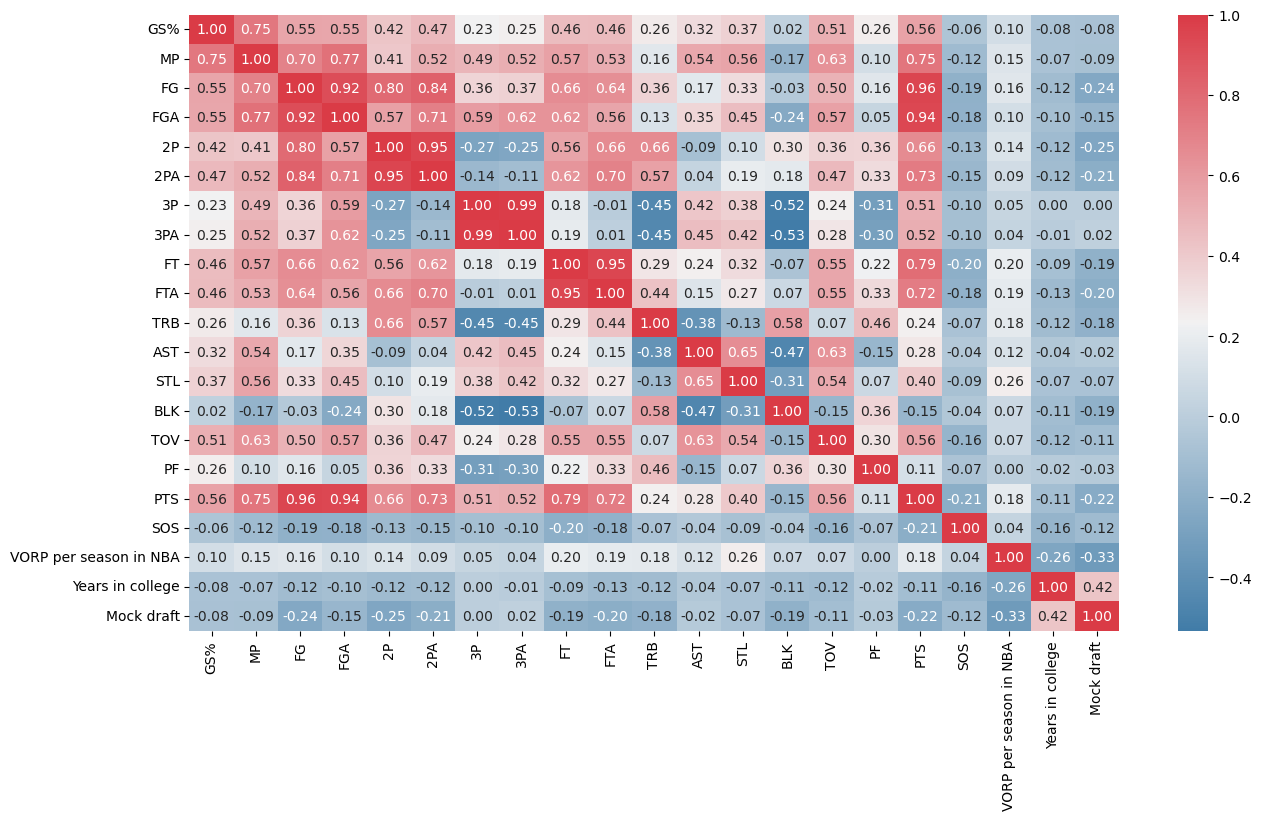

In [54]:
plt.figure(figsize=(15,8))
cmap = sb.diverging_palette(240, 10, as_cmap=True)
dataplot = sb.heatmap(corr1.corr(), cmap=cmap, annot=True, fmt='.2f')
plt.show()

High correlation (>= 0.7):
MP <-> GS% (0.75)
FG, FGA <-> MP (0.7, 0.77)
PTS <-> MP (0.75)
FGA <-> FG (0.92)
2P, 2PA <-> FG (0.8, 0.84)
PTS <-> FG (0.96)
2PA <-> FGA (0.71)
PTS <-> FGA (0.94)
2PA <-> 2P (0.95)
FTA <-> 2PA (0.7)
PTS <-> 2PA (0.73)
3P <-> 3PA (0.99)
FTA <-> FT (0.95)
PTS <-> FT (0.79)
PTS <-> FTA (0.72)

Conclusion:
2P, 2PA substitute with 2P%
3P, 3PA substitute with 3P%
FG, FGA substitute with FG%
FT, FTA substitute with FT%
MP - substitute PTS with PTS per 40 minutes
Remove GS%

In [55]:
corr2 = data.iloc[:, [4, 5, 8, 11, 14, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33]]

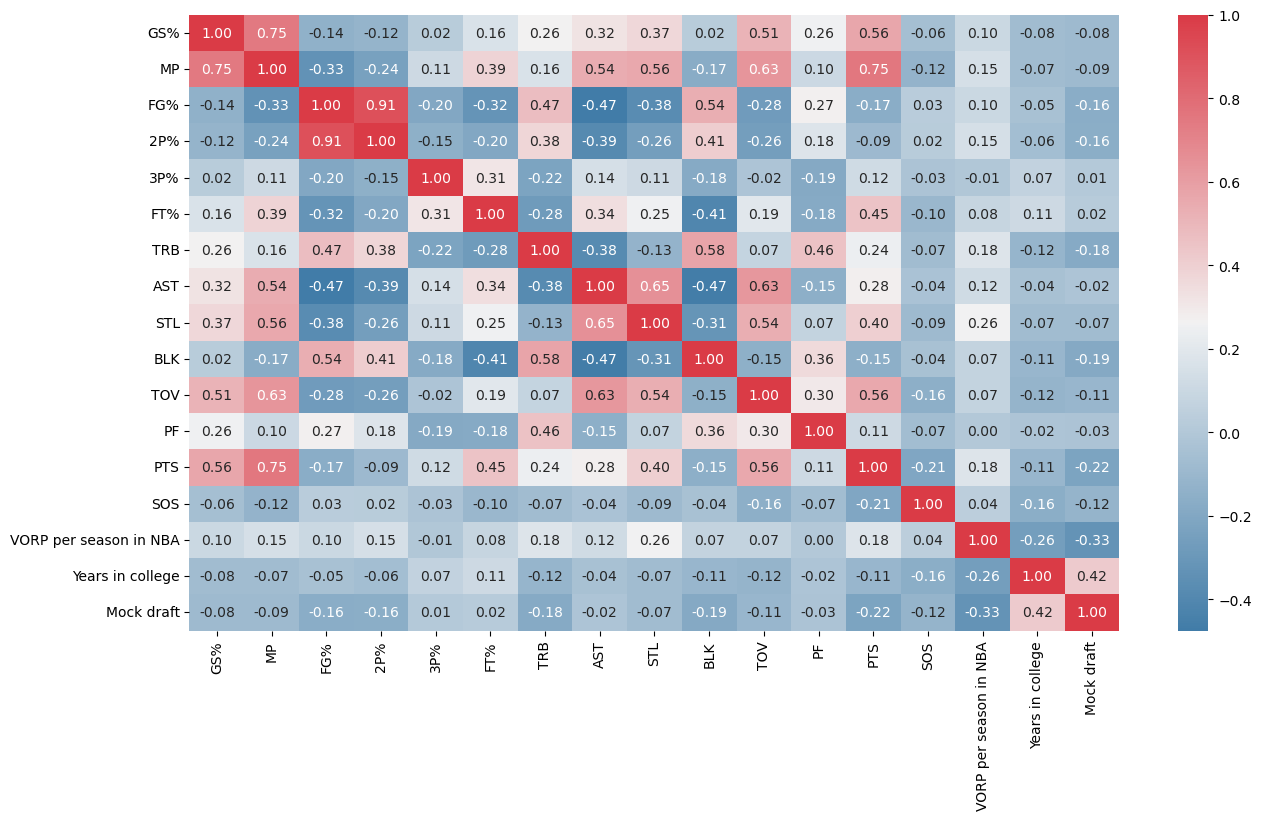

In [56]:
plt.figure(figsize=(15,8))
cmap = sb.diverging_palette(240, 10, as_cmap=True)
dataplot = sb.heatmap(corr2.corr(), cmap=cmap, annot=True, fmt='.2f')
plt.show()

High correlation:
2P% <-> FG% (0.91)
PTS <-> MP (0.75)

Conclusion:
Remove 2P%
Substitute PTS with PTS per 40 minutes

In [81]:
corr3 = data.iloc[:, [5, 8, 14, 17, 20, 21, 22, 23, 24, 27, 29, 32, 33, 37]]

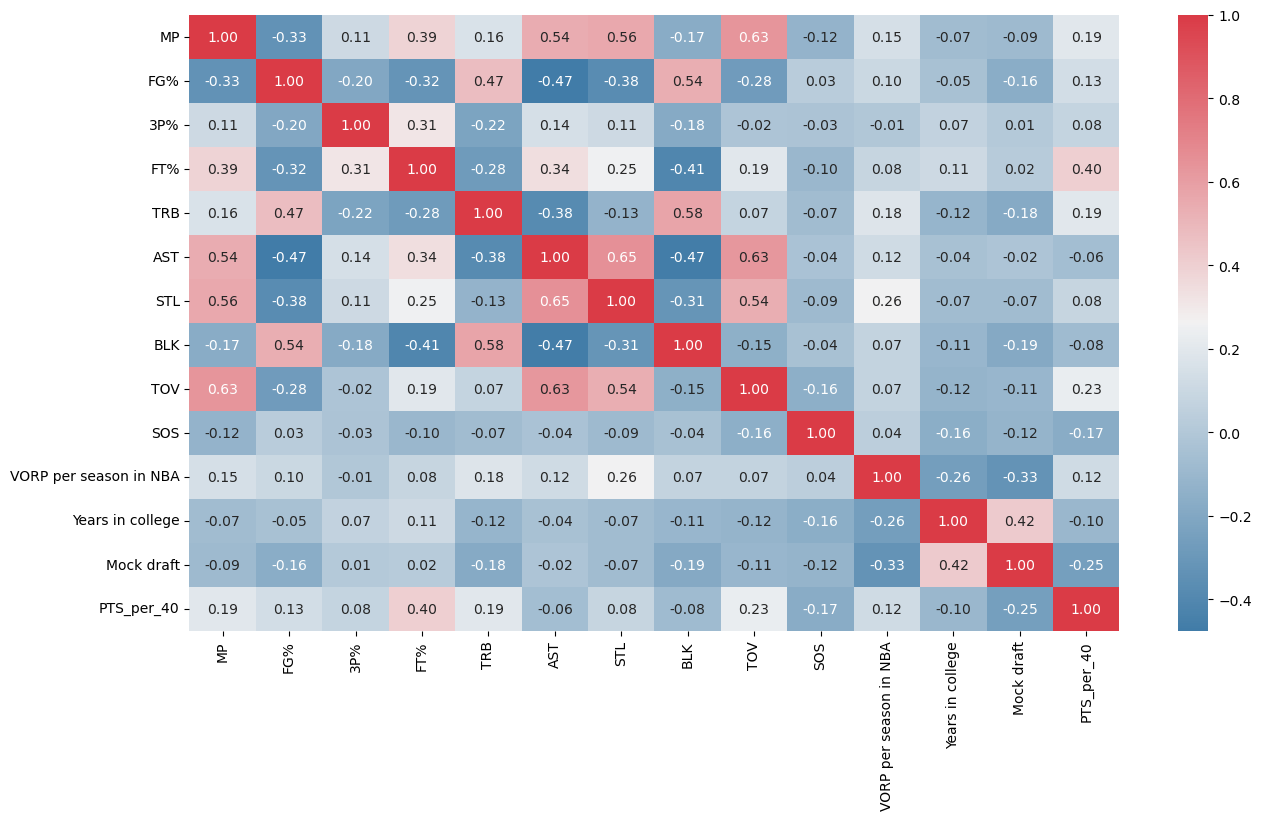

In [82]:
plt.figure(figsize=(15,8))
cmap = sb.diverging_palette(240, 10, as_cmap=True)
dataplot = sb.heatmap(corr3.corr(), cmap=cmap, annot=True, fmt='.2f')
plt.show()